In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
from dataset_construction.extract_annotated_frames_from_mha import extract_annotated_frames
from dataset_construction.calculate_ac_from_mask import fit_ellipse_ac_mm
from dataset_construction.check_ellipse_quality import check_ellipse_quality

# 1. Extract annotated frames from mha

In [2]:
# root_dir = "F:/projectData/test"
root_dir = "F:/projectData/acouslic-ai-train-set"
output_dir = "../../training_data/segmentation_dataset"
extract_annotated_frames(root_dir, output_dir)

Processing 0199616b-bdeb-4119-97a3-a5a3571bd641...
Processing 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1...
Processing 02ee26a5-a665-4531-bec1-8bac83345a94...
Processing 032b9024-3685-4a81-a62e-813d2da3d387...
Processing 0428da3d-fef4-4c9b-96f2-5ffedaee82d0...
Processing 046ed03e-4b35-4519-bb5f-cd4b0474a060...
Processing 04a04f2e-840b-47f8-a907-abe7aeab3f41...
Processing 04ef1176-7d54-4942-899d-f0fa69ad34bb...
Processing 056764b4-7c0c-4452-832d-3d1cbb5a0464...
Processing 05f72776-bf41-40ea-bdea-a7bcfa1eb9ba...
Processing 0607eff0-2268-46b6-8fb8-16e40a521a42...
Processing 0658cdf9-53bc-46a9-ae86-cc99a6fc5e77...
Processing 0685cfaf-d585-40b3-a365-52f70f2536b6...
Processing 069c0349-1e8d-42d0-afa1-69c7114a742f...
Processing 071ee12c-a8a5-45fd-b191-fd5ec3b00766...
Processing 09ddeecb-72e0-417a-85fd-77d397f6219d...
Processing 0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06...
Processing 0d7c4d8f-6e07-4f2b-aa76-8915ce15a38f...
Processing 0e2631b6-ed14-4ce4-bc17-896590c406fd...
Processing 0f32e98f-8257-4649-a

# 2. Calculate AC from mask

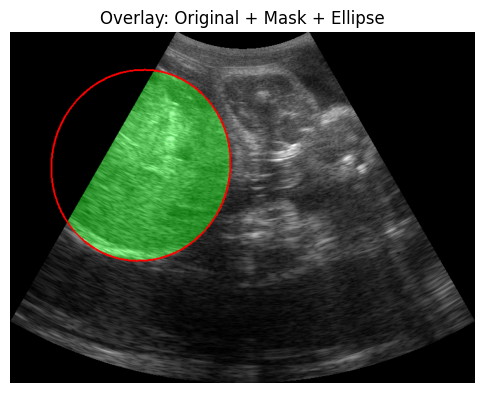

Fit ellipse ≈ 261.43 mm


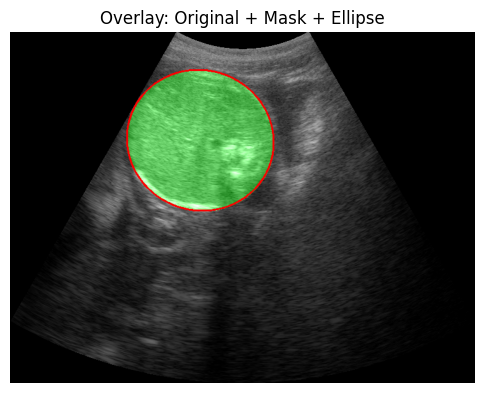

Fit ellipse ≈ 203.11 mm


In [2]:
mask_path = "../../training_data/segmentation_dataset/masks/frame_000123.png"
perimeter = fit_ellipse_ac_mm(mask_path, show_plot=True)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

mask_path = "../../training_data/segmentation_dataset/masks/frame_000500.png"
perimeter = fit_ellipse_ac_mm(mask_path, show_plot=True)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

In [3]:
mask_dir = "../../training_data/segmentation_dataset/masks"
output_json = "../../training_data/ac_results.json"
ac_results = {}
mask_files = sorted(glob(os.path.join(mask_dir, "*.png")))

for path in mask_files:
    filename = os.path.basename(path)
    try:
        ac_value = fit_ellipse_ac_mm(path, show_plot=False)
        ac_results[filename] = {"ac_mm": round(ac_value, 2)}
    except Exception as e:
        ac_results[filename] = {"ac_mm": None}
        print(f"{filename} fitting error: {e}")

with open(output_json, "w") as f:
    json.dump(ac_results, f, indent=2)

print(f"AC calculation completed, a total of {len(mask_files)} images processed, results saved as {output_json}")

AC calculation completed, a total of 6620 images processed, results saved as ../../training_data/ac_results.json


In [6]:
# folder_path = "../../training_data/segmentation_dataset/masks"
# for filename in sorted(os.listdir(folder_path)):
#     if filename.endswith(".png"):
#         mask_path = os.path.join(folder_path, filename)
#         perimeter = fit_ellipse_ac_mm(mask_path, show_plot=False)
#         print(f"{filename}: Fit ellipse ≈ {perimeter:.2f} mm")

# 3. Ellipse Shape Completeness Check

In [2]:
with open("../../training_data/ac_results.json", "r") as f:
    ellipse_data = json.load(f)

for filename in tqdm(ellipse_data):
    mask_path = os.path.join("../../training_data/segmentation_dataset/masks", filename)
    gt_ac = ellipse_data[filename]["ac_mm"]

    is_valid, ac_cv, err = check_ellipse_quality(mask_path, gt_ac)
    ellipse_data[filename]["is_complete"] = is_valid
    ellipse_data[filename]["cv_fit_ac_mm"] = ac_cv
    ellipse_data[filename]["cv_fit_error_ratio"] = round(err, 4)

with open("../../training_data/ellipse_info_checked.json", "w") as f:
    json.dump(ellipse_data, f, indent=2)


100%|██████████| 6620/6620 [00:13<00:00, 508.75it/s]


In [5]:
import json

def count_validity_flags(json_path, key_name="is_complete"):
    with open(json_path, "r") as d:
        data = json.load(d)

    count_true = 0
    count_false = 0
    count_missing = 0

    for item in data.values():
        if key_name not in item:
            count_missing += 1
            continue
        if item[key_name]:
            count_true += 1
        elif not item[key_name]:
            count_false += 1

    print(f"{key_name} = True:  {count_true}")
    print(f"{key_name} = False: {count_false}")
    if count_missing > 0:
        print(f"Missing '{key_name}' field: {count_missing}")

count_validity_flags("../../training_data/ellipse_info_checked.json", key_name="is_complete")


is_complete = True:  4116
is_complete = False: 2504
